# Unit Testing Optimisation

## Importing the Packages

In [720]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm
import os

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [721]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [722]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [723]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Plotting

### Dimensions

In [724]:
def set_size_wide(width_pt=426.79135, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return [fig_width_in, fig_height_in]

In [725]:
def set_size_tall(width_pt=426.79135, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * (1 / golden_ratio) * (subplots[0] / subplots[1])

    return [fig_width_in, fig_height_in]

In [726]:
def set_size_square(width_pt=426.79135, fraction=1):
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in 

    return [fig_width_in, fig_height_in]

### Plots

In [727]:
def plotline(X, Y, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35, Line = [1.0]):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth = Line[i])

  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.autoscale(enable=True, axis='x', tight=True)

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

In [793]:
def plotfilt(X, Y, ScattX, ScattY, FillX, ErrorBars, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], ScattL="", Name="", Fract=0.35, Legend=False):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )
  Lines = [0] * len(X)
  for i in range(len(X)):
    Lines[i] = Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i])

  Ax.fill_between(FillX, *ErrorBars, alpha = 0.3, zorder=1)
  Ax.scatter(ScattX, ScattY, s = 50, label = ScattL, marker = '+', c='r', alpha = 0.8, zorder = 5)
  
  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.set_xlim([0.0, 1.0])

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 4, columnspacing = 0.7)

  Ax.lines.pop(-1)
  plt.draw()
  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)
  if Legend:
    Legfig.savefig(Filepath + "/" + Name + 'Legend' + '.pgf', format = 'pgf', bbox_inches = 'tight')

In [729]:
def plotout(X, Y, FillX, ErrorBars, Colors = ["tab:blue", "tab:orange"],
            Labels = ["Model Prediction", "Ground Truth"], Name="", Fract=0.35):
  Axsize = set_size_wide(fraction=Fract)
  Fsize1 = (Axsize[0] + 1.4, Axsize[1] + 0.9)
  Fig = plt.figure(figsize=Fsize1)
  Legfig = plt.figure()
  H = [Size.Scaled(1), Size.Fixed(Axsize[0]), Size.Scaled(1)]
  V = [Size.Scaled(1), Size.Fixed(Axsize[1]), Size.Scaled(1)]
  Div = Divider(Fig, (0, 0, 1, 1), H, V, aspect=False)
  Ax = Fig.add_axes(
      Div.get_position(), axes_locator=Div.new_locator(nx=1, ny=1)
  )

  for i in range(len(X)):
    Ax.plot(X[i], Y[i], color = Colors[i], label = Labels[i], linewidth=0.4 * (2 * i + 1), zorder = i)

  Ax.fill_between(FillX, *ErrorBars, alpha = 0.3, zorder=1)
  
  Ax.set_xlabel(r"{Time ($s$)}")
  Ax.set_ylabel(r"{Speed $\left(\frac{m}{s}\right)$}")

  Ax.autoscale(enable=True, axis='x', tight=True)

  Lns, Lbl = Ax.get_legend_handles_labels()
  Legfig.legend(Lns, Lbl, loc='center', ncol = 2)

  Filepath = os.path.abspath('/home/sgome/Project/Reports/Final-Report/Figures/')
  print(Filepath + "/" + Name + '.pgf')
  Fig.savefig(Filepath + "/" + Name + '.pgf', transparent = True, format = 'pgf', pad_inches = 0.0)

## Creating Test Data

In [730]:
key = random.PRNGKey(6)
key, *subkeys = random.split(key, 4)

In [731]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [732]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 10.0

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.01, (k+1,)).astype(np.float64)

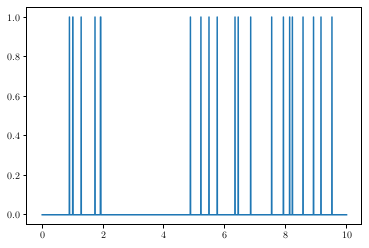

In [733]:
plt.plot(xtime, xtest)

### True Filter

In [734]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 1.00

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# Damped frequency
w_d = 18.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.09)

# Sqrt True diff
tau_diff = np.sqrt(0.001)

# True lag
lag = 0.05

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))) * env_true

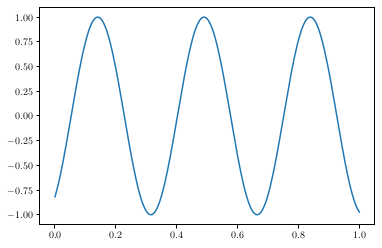

In [735]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

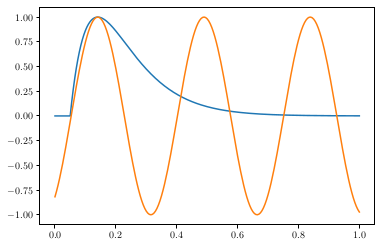

In [736]:
plt.plot(ftime, env_true)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

/home/sgome/Project/Reports/Final-Report/Figures/True Filter.pgf


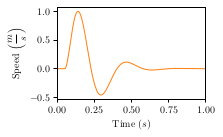

In [737]:
plotline([ftime], [ftrue], ["tab:orange"], ["True Filter"], Name = "True Filter")

### True Noise

In [738]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.5

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [739]:
# Padding and applying the FFT
xpad = np.append(xtest, np.zeros(n))
fpad = np.append(ftrue, np.zeros(k))

x_fft = np.fft.rfft(xpad)
f_fft = np.fft.rfft(fpad)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [740]:
# Showing equals the raw convolution
yffttest = np.convolve(xtest, ftrue)[:k + 1] + noise_vec

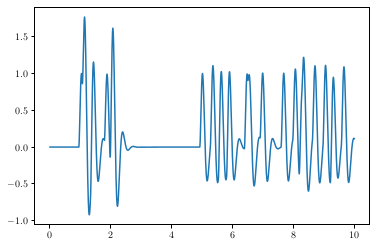

In [741]:
plt.plot(ytime, ynonoise)

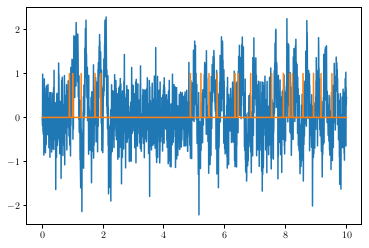

In [742]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

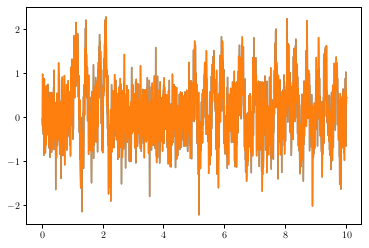

In [743]:
plt.plot(ytime, yffttest)
plt.plot(ytime, ytest)

/home/sgome/Project/Reports/Final-Report/Figures/Synthetic Output.pgf


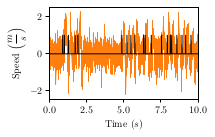

In [744]:
plotline([ytime, ytime], [ytest, xtest], ['tab:orange', 'k'], ["Observed Data", "Spike Train"], Name = "Synthetic Output", Line=[0.5, 1.0])

## Variational Inference

### ELBO

#### Kl Divergence Term

In [745]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [746]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Pad, Sigma_n, N, K, Y_Test, X_Fft):

  F_Fft = jnp.fft.rfft(F_Pad)

  Mean = jnp.fft.irfft(X_Fft * F_Fft, N + K + 1)[: K + 1]
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [747]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [1, None, None, None, None, None]),
             static_argnums = (2,3,))

#### Expected Log-Likelihood

In [748]:
@partial(jit, static_argnums = range(9,13))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):

  K_MM = Squared_exp(Z_Vector, Z_Vector.T, Sigma_f, Ell)
  K_MN = Squared_exp(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Squared_exp(F_Time, F_TimeT, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  BT = B.T

  Mu_q = B.T @ V_Vector

  V_q = K_NN + BT @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = (Mu_q + Chol_Vq @ random.normal(Subkey, (N + 1, Number_F))) * AlpEnvelope(F_TimeT, TRise, TauDiff, Lag)

  F_Samples = jnp.vstack((F_Samples, jnp.zeros((K, Number_F))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

In [749]:
test_number_f = 100
test_m = int(1000)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1))
test_v_m = np.zeros(test_m).reshape((test_m, 1))
test_l_mm = np.eye(test_m)
test_trise = 0.02
test_tdecay = 0.03
test_lag = 0.01

In [750]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_trise, test_tdecay, test_lag, test_number_f, test_m, n, k, ytest, x_fft, ftime, ftime.reshape((n + 1, 1)), test_key))

-183690.94000208483


#### ELBO

In [751]:
@partial(jit, static_argnums = range(10, 14))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F,
         M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):
         
  Lag = Lag ** 2.0
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1] - Lag) + Lag

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  
  return (KL-Exp)/(K + 1)

In [752]:
test_number_f = 100
test_m = 200
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1))
test_v_m = 5.0 * np.ones((test_m, 1))
test_l_diag = np.ones(test_m)
test_l_odiag = np.tril(np.zeros((test_m, test_m)), -1)[np.tril_indices(test_m, -1)]
test_trise = 0.02
test_tdecay = 0.03
test_lag = 0.01

In [753]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdecay, test_lag, test_number_f, test_m, n, k, ytest, x_fft, ftime, ftime.reshape((n + 1, 1)), test_key))

2367.7335671586247


In [754]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 14))

### Optimiser

#### Sub-function Definitions

In [755]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [756]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [757]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [758]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [759]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [760]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [761]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [762]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [763]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [764]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [765]:
@partial(jit, static_argnums = range(12,16))
def _CUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

In [766]:
@partial(jit, static_argnums = range(12,16))
def _MUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

In [767]:
@partial(jit, static_argnums = range(12,16))
def _FUpdate(Iter, X, Subkey, Key, ELBO_History, Step, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT,
             Num_Coarse_Fs, M, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkey, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [768]:
@partial(jit, static_argnums = range(5, 9))
def AdamOpt(Init_Params, X_Fft, Y_Test, F_Time, F_TimeT, M, N, K, Num_Fs,              
                        Coarse_Schedule = jnp.asarray([400, 400, 700]), Mid_Schedule = jnp.asarray([16500]),
                        Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(20000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(20)
  Key, Subkey = random.split(Key)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Y_Test, X_Fft, F_Time, F_TimeT, Num_Fs, M, N, K)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, (Params, Subkey, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [769]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 5.0
iell = 0.002
isigma_n = 0.000000005


itrise = np.sqrt(0.05)
itaudiff = np.sqrt(0.1)
ilag = np.sqrt(0.01)

# Variational parameters
num_ind = 30
# iz_fracs = [0.0]
# for i in range(num_ind - 1):
#   iz_fracs.append(np.sqrt(iz_fracs[i]**2 + 1/num_ind))
# iz_fracs = jnp.asarray(iz_fracs).reshape((num_ind, 1))
iz_final = jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
# iz_vector = jnp.linspace(ftime[0], ftime[-1], num_ind).reshape((num_ind, 1))
key, *subkeys = random.split(key, 4)
iv_vector = (jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-3], (num_ind,))).reshape((num_ind, 1))
il_diag = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-2], (num_ind,))
il_odiag = jnp.zeros(int((num_ind ** 2 - num_ind) / 2)) + \
            0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),))
num_f = 100
ftimet = ftime.reshape((n + 1, 1))

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, opt_subkey = random.split(opt_key)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, n, k, ytest, x_fft, ftime, ftimet)

In [770]:
fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [771]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [772]:
print(Neg_ELBO(*params, num_f, *consparams, opt_subkey))

2.0453767474899974e+17


In [773]:
print(Neg_ELBO(*fparams, num_f, *consparams, opt_subkey))
# -1.497760096 w full constriction
# -1.500115562 w one side constriction
# -1.362569860 w no constriction

0.7414041557608902


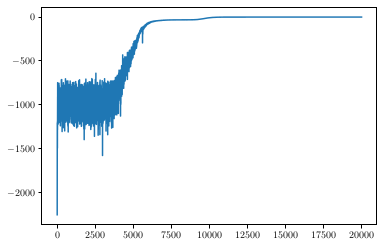

In [774]:
plt.plot(elbo_history[10:])

In [775]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [776]:
ilag = ilag ** 2

iz_vector = (0.5 * jnp.sin( jnp.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1] - ilag) + ilag

id = np.diag(np.exp(il_diag))
il_matrix = id + np.zeros(num_ind)
il_matrix[np.tril_indices(num_ind, -1)] = il_odiag


flag = flag ** 2

fz_vector = (0.5 * jnp.sin( jnp.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag) + flag

fd = np.diag(np.exp(fl_diag))
fl_matrix = fd + np.zeros(num_ind)
fl_matrix[np.tril_indices(num_ind, -1)] = fl_odiag

In [777]:
print(fsigma_f)

2.03539196626211


In [778]:
print(fell)

-0.11386280562347652


In [779]:
print(fsigma_n)

0.5042772371555457


In [780]:
print(ftrise)

0.25995211991681927


In [781]:
print(ftaudiff)

0.0663110898703881


In [782]:
print(flag)

0.05905108217318733


## Variational Predictions

In [783]:
fpred_points = ftimet.copy()

In [784]:
ikmm = Squared_exp(iz_vector, iz_vector.T, isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vector, fpred_points.T, isigma_f, iell)
ibzast = sc.linalg.solve_triangular(icpred, ikzast, lower = True)
ipredenv = AlpEnvelope(fpred_points, itrise, itaudiff, ilag)
imeanpred = ipredenv * (ibzast.T @ iv_vector)

ikastast = Squared_exp(fpred_points, fpred_points.T, isigma_f, iell)
icovpred = ipredenv * (ikastast + ibzast.T @ (il_matrix @ il_matrix.T - np.eye(num_ind)) @ ibzast) * ipredenv.T

In [785]:
kmm = Squared_exp(fz_vector, fz_vector.T, fsigma_f, fell)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Squared_exp(fz_vector, fpred_points.T, fsigma_f, fell)
bzast = sc.linalg.solve_triangular(cpred, kzast, lower = True)
predenv = AlpEnvelope(fpred_points, ftrise, ftaudiff, flag)
meanpred = predenv * (bzast.T @ fv_vector)

kastast = Squared_exp(fpred_points, fpred_points.T, fsigma_f, fell)
covpred = predenv * (kastast + bzast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ bzast) * predenv.T

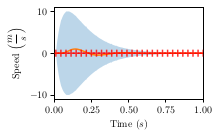

<Figure size 432x288 with 0 Axes>

In [794]:
ipredindenv = AlpEnvelope(iz_vector, itrise, itaudiff, ilag)
is2 = np.sqrt(np.diag(icovpred))
ifill = (imeanpred.flatten() - 2*is2, imeanpred.flatten() + 2*is2)
plotfilt([ftime, fpred_points.flatten()],[ftrue, imeanpred.flatten()], 
          iz_vector, ipredindenv * (cpred @ iv_vector), fpred_points.flatten(), ifill, Colors=["tab:orange", "tab:blue"], Labels=["Ground Truth", "Model Prediction"],
          Name = "Initial Prediction Filter", ScattL = "Inducing Points")

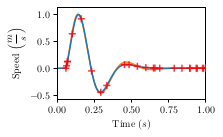

<Figure size 432x288 with 0 Axes>

In [791]:
fpredindenv = AlpEnvelope(fz_vector, ftrise, ftaudiff, flag)
s2 = np.sqrt(np.diag(covpred))
fill = (meanpred.flatten() - 2*s2, meanpred.flatten() + 2*s2)
plotfilt([ftime, fpred_points.flatten(), xtime],[ftrue, meanpred.flatten(), xtest], 
          fz_vector, fpredindenv * (cpred @ fv_vector), fpred_points.flatten(), fill, Colors=["tab:orange", "tab:blue", "k"], Labels=["Ground Truth", "Model Prediction", "Input Spike Train"],
          Name = "Final Prediction Filter", ScattL = "Inducing Points", Legend=True)

/home/sgome/Project/Reports/Final-Report/Figures/Initial Prediction Output.pgf


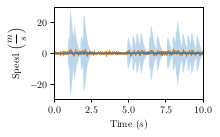

<Figure size 432x288 with 0 Axes>

In [788]:
ioutfill = (np.convolve(xtest, imeanpred.flatten() - 2*is2)[: k + 1] - 2 * isigma_n,
             np.convolve(xtest, imeanpred.flatten() + 2*is2)[: k + 1] + 2 * isigma_n)
plotout([ytime] * 2, [ytest, np.convolve(xtest, imeanpred.flatten())[: k + 1]], 
          ytime, ioutfill, Name = "Initial Prediction Output",  Colors=["tab:orange", "tab:blue"])

/home/sgome/Project/Reports/Final-Report/Figures/Final Prediction Output.pgf


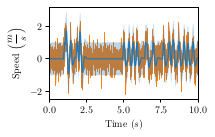

<Figure size 432x288 with 0 Axes>

In [789]:
foutfill = (np.convolve(xtest, meanpred.flatten() - 2*s2)[: k + 1] - 2 * fsigma_n,
             np.convolve(xtest, meanpred.flatten() + 2*s2)[: k + 1] + 2 * fsigma_n)
plotout([ytime] * 2, [ytest, np.convolve(xtest, meanpred.flatten())[: k + 1]], 
          ytime, foutfill, Name = "Final Prediction Output", Colors=["tab:orange", "tab:blue"])